In [1]:
import os, sys
from pathlib import Path
home = str(Path.home())
core_dir = home+'/repositories/ai-x/core'
sys.path.insert(0, core_dir)
selectivity_dir = core_dir + "/selectivity"
sys.path.insert(0, selectivity_dir)

core_dir = home+'/repositories/ai-DR/core'
sys.path.insert(0, core_dir)

from dataset_characteristics import *
from selectivity import *

def save_file(df, filename):
    df_act = df[["CHEMBL",'pKi']]
    df_smi = df[['canonical_smiles','CHEMBL']]
    df_act.to_csv(filename+'.act', sep='\t', index=False, header = False)
    df_smi.to_csv(filename+'.smi', sep='\t', index=False, header = False)

# command line arguments
chembl_version = "C33"
n = 0
num_of_val = 1

filters package has been imported!


In [2]:
datadir = home + "/repositories/ai-DR/datasets/chembl_datasets/"
path1 = datadir + "C33/dataset_D2_antagonist_Ki/pubdata"
path2 = datadir + "C33/dataset_D3_antagonist_Ki/pubdata"

d2 = get_df(path1)  # get df with columns containing chembl, pki, and smile string
d3 = get_df(path2)  # get df with columns containing chembl, pki, and smile string
d2 = check_similarity_within_df(d2)  # checks if there are any similar compounds within its own df
d3 = check_similarity_within_df(d3)  # checks if there are any similar compounds within its own df

mol_dup_pairs = get_mol_dup_pairs(d2, d3)  # a paired set, referring to similar indexes between d2 and d3
ls_i = []
ls_j = []
for i, j in mol_dup_pairs:
    ls_i.append(i)
    ls_j.append(j)
    
d2_unique = d2.loc[~d2.index.isin(ls_i)].reset_index(drop=True)
d3_unique = d3.loc[~d3.index.isin(ls_j)].reset_index(drop=True)
    
save_file(d2_unique, "unique_dataset/d2_unique_Ki")
save_file(d3_unique, "unique_dataset/d3_unique_Ki")

In [3]:
datadir = home + "/repositories/ai-DR/datasets/chembl_datasets/"
path1 = datadir + "C33/dataset_D2_antagonist_IC50/pubdata"
path2 = datadir + "C33/dataset_D3_antagonist_IC50/pubdata"

d2 = get_df(path1)  # get df with columns containing chembl, pki, and smile string
d3 = get_df(path2)  # get df with columns containing chembl, pki, and smile string
d2 = check_similarity_within_df(d2)  # checks if there are any similar compounds within its own df
d3 = check_similarity_within_df(d3)  # checks if there are any similar compounds within its own df

mol_dup_pairs = get_mol_dup_pairs(d2, d3)  # a paired set, referring to similar indexes between d2 and d3
ls_i = []
ls_j = []
for i, j in mol_dup_pairs:
    ls_i.append(i)
    ls_j.append(j)
    
d2_unique = d2.loc[~d2.index.isin(ls_i)].reset_index(drop=True)
d3_unique = d3.loc[~d3.index.isin(ls_j)].reset_index(drop=True)
    
save_file(d2_unique, "unique_dataset/d2_unique_IC50")
save_file(d3_unique, "unique_dataset/d3_unique_IC50")

In [47]:
def gaussian_distribution(dataset, ls_colors, selectivity = False, save2png = False):
    dataset = sorted(dataset)
    ls_act_files = []
    for data in dataset:
        ls_act_files.append(f"unique_dataset/{data}.act")
    ls_act_files = sorted(ls_act_files)

    ls_act_names = []  # filename; do this separately, in order to sort the names
    for i in range(len(ls_act_files)):
        ls_act_names.append(ls_act_files[i].split('/')[-1])

    ctrl_nbin = 20
    if selectivity:
        act_min = -4
        act_max = 4
    else:
        act_min = 2
        act_max = 12

    ls_act_data = []  # read-in data
    ls_act_data_hist_counts = []  # read-in data after binning; y
    ls_act_data_hist_bins = []  # read-in data after binning; x
    ls_act_data_peak_x = []  # peak value at x
    ls_act_data_peak_y = []  # peak value at x

    for i in range(len(ls_act_files)):
        if selectivity:
            ls_act_data.append(-1*get_data(ls_act_files[i]))
        else:
            ls_act_data.append(get_data(ls_act_files[i]))
        ## binning
        yhist, bins = np.histogram(ls_act_data[i], bins=ctrl_nbin, range=[act_min, act_max], density=False)
        ## calculate probability instead of using density to avoid sum is not 1
        yhist = yhist / sum(yhist)
        # manipulate bin
        bin_shift = (bins[1] - bins[0]) / 2
        nbin_center = len(bins) - 1
        xbin = bins + bin_shift
        xbin = xbin[0:nbin_center]
        # smooth x, y datapoints
        xbin_smooth, yhist_smooth = get_smooth(xbin, yhist)
        # return to array
        ls_act_data_hist_counts.append(yhist_smooth)
        ls_act_data_hist_bins.append(xbin_smooth)
        # find the peak
        ls_act_data_peak_x.append(list(xbin_smooth[yhist_smooth == max(yhist_smooth)])[0])
        ls_act_data_peak_y.append(list(yhist_smooth[yhist_smooth == max(yhist_smooth)])[0])

    maxylim = 0.32
    linewidth = 1.5
    figwidth = 5.4
    figheight = figwidth
    fig, ax = plt.subplots(figsize=(figwidth, figheight), facecolor='w', edgecolor='k')

    ls_lines = count_lines(ls_act_files)
    for i in range(len(ls_act_names)):
        ax.set_ylim(0, maxylim)
        ax.plot(ls_act_data_hist_bins[i], ls_act_data_hist_counts[i], lw=linewidth, label=ls_act_names[i], color = ls_colors[i])
        ax.plot([ls_act_data_peak_x[i] for a in range(2)], [0, ls_act_data_peak_y[i]], lw=linewidth, linestyle='dashed', color = ls_colors[i])

        if save2png:
            ax.tick_params(bottom = True, top = True, left = True, right = True, labelbottom=False, labelleft=False)
            plt.savefig(save2png, dpi = 300, transparent = True, bbox_inches = "tight")
        else:
            # peak label
            ax.text(ls_act_data_peak_x[i] - 0.7, ls_act_data_peak_y[i] + 0.04, str(round(ls_act_data_peak_x[i], 1)),
                    fontsize=12, color=ls_colors[i])
            # label # of compounds
            ax.text(10+i, 0.3, ls_lines[i], fontsize=12, color=ls_colors[i])
            ax.legend(loc="upper left", bbox_to_anchor=(1, 0.9), prop={'size': 12})

    plt.show()
    

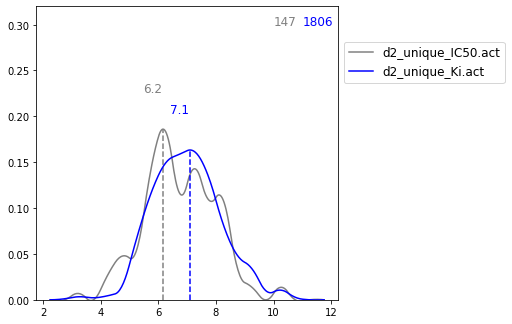

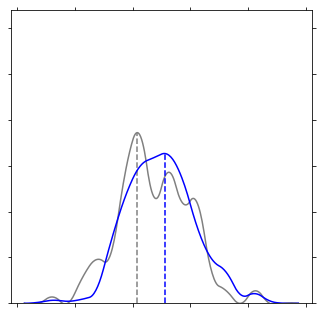

In [61]:
%matplotlib inline

color_IC = "grey"
# ls_colors = ["navy", "deepskyblue", "darkred", "orangered"]
# datasets = ["d2_unique_Ki","d2_unique_IC50", "d3_unique_Ki", "d3_unique_IC50"]
ls_colors = [color_IC, "blue"]
datasets = ["d2_unique_IC50", "d2_unique_Ki"]
gaussian_distribution(datasets, ls_colors, selectivity = False, save2png = False)
gaussian_distribution(datasets, ls_colors, selectivity = False, save2png="output_dir/distribution_D2_specific.png")

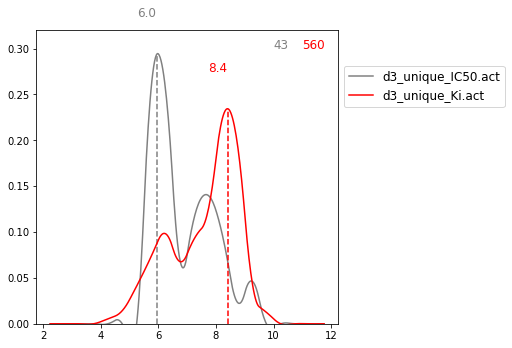

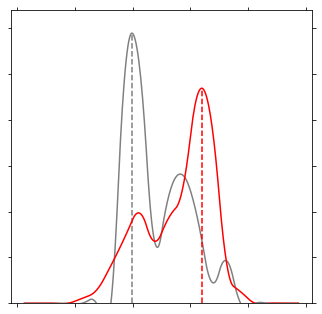

In [62]:
ls_colors = [color_IC, "red"]
datasets = ["d3_unique_IC50", "d3_unique_Ki"]
gaussian_distribution(datasets, ls_colors, selectivity = False, save2png = False)
gaussian_distribution(datasets, ls_colors, selectivity = False, save2png="output_dir/distribution_D3_specific.png")

In [ ]:
%matplotlib inline

ls_colors = ["blue", "red"]
datasets = ["unique_dataset/d3_unique_Ki.act","unique_dataset/d3_unique_IC50.act"]
gaussian_distribution(datasets, ls_colors, selectivity = False, save2png = False)